In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

data = pd.read_csv('logs/bo_runs_data_tempswing_reduziert_Vext_densB_new.csv')
doto = pd.read_csv('logs/gp_summary_data_tempswing_reduziert_Vext_densB_new.csv', on_bad_lines='skip')

In [11]:
counts = data['found_global_best'].value_counts()
print(counts)

found_global_best
True     2
False    2
Name: count, dtype: int64


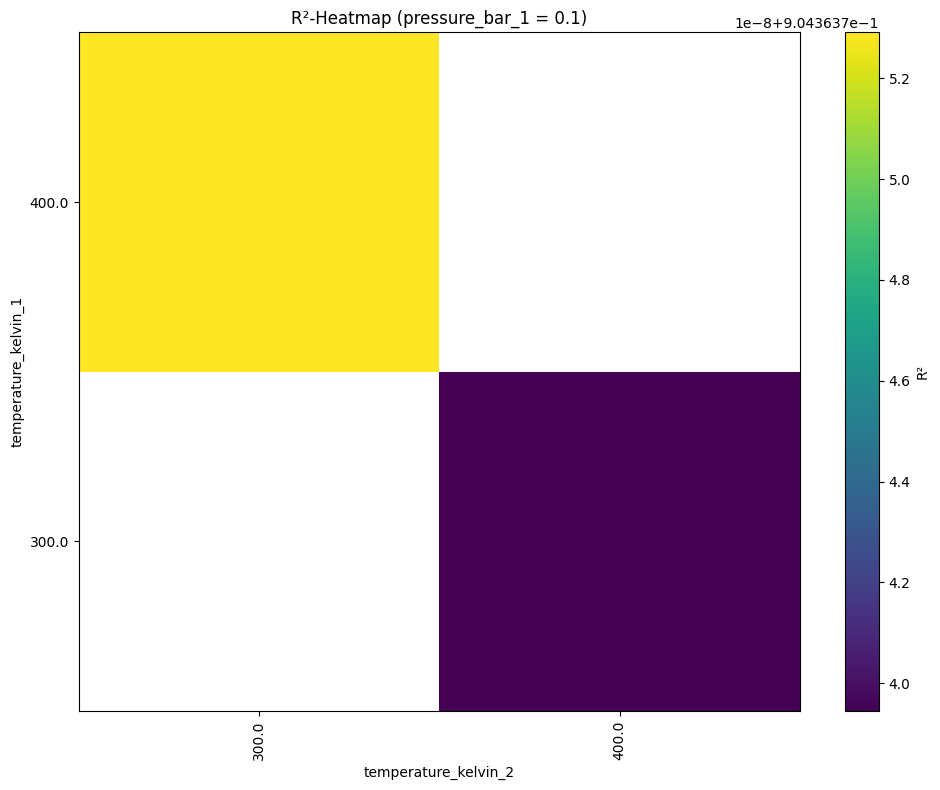

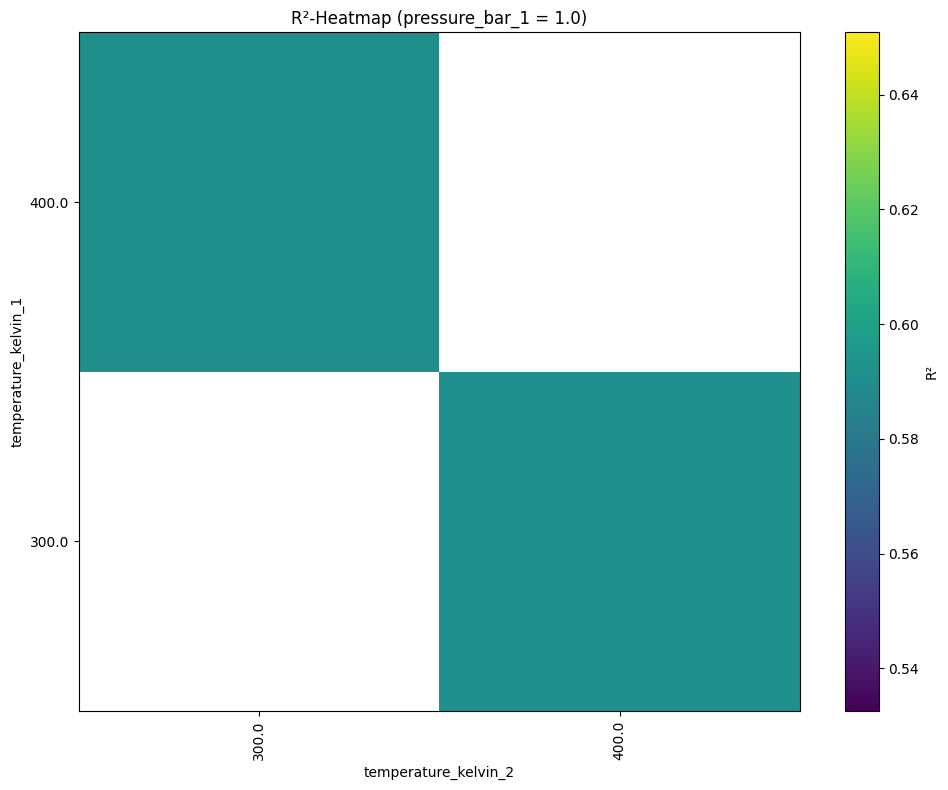

In [12]:
pressures = np.sort(doto["pressure_bar_1"].unique())

for p in pressures:
    # 2) Nicht das Original-DF überschreiben; Subset je Druck bauen
    sub = doto[doto["pressure_bar_1"].eq(p)]

    if sub.empty:
        continue  # falls numerische Toleranzen o.ä.

    # 3) Pivot-Table (optional: Mittelwert bei Duplikaten)
    heatmap_data = sub.pivot_table(
        index="temperature_kelvin_1",
        columns="temperature_kelvin_2",
        values="r2",
        aggfunc="mean"
    )

    # Optional: sortierte Achsen (macht die Heatmap „ordentlicher“)
    heatmap_data = heatmap_data.sort_index().sort_index(axis=1)

    # 4) Plot
    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap_data.values, aspect='auto', origin='lower')
    plt.colorbar(label='R²')

    plt.title(f"R²-Heatmap (pressure_bar_1 = {p})")
    plt.xlabel("temperature_kelvin_2")
    plt.ylabel("temperature_kelvin_1")

    # Achsen-Ticks passend zu den DataFrame-Achsen setzen
    plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns, rotation=90)
    plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)

    plt.tight_layout()
    plt.show()

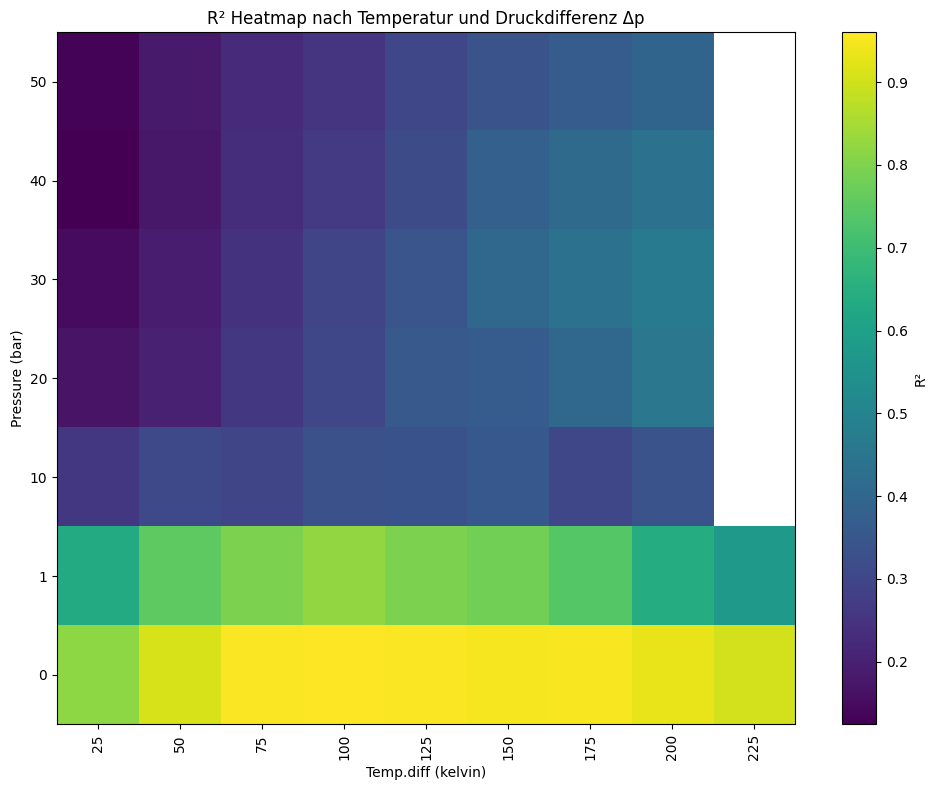

In [4]:
doto["delta_t"] = (doto["temperature_kelvin_2"] - doto["temperature_kelvin_1"]).abs()

# --- Pivot-Tabelle: Temperatur vs Δp ---
heatmap_data = doto.pivot_table(
    index="pressure_bar_1",   # Y-Achse
    columns="delta_t",            # X-Achse
    values="r2",                  # Farbe repräsentiert R²
    aggfunc="mean"                # Mittelwert, falls mehrere Kombinationen
)

# --- Sortierung (optional, für saubere Achsen) ---
heatmap_data = heatmap_data.sort_index().sort_index(axis=1)

# --- Plot ---
plt.figure(figsize=(10, 8))
im = plt.imshow(heatmap_data, aspect="auto", origin="lower", cmap="viridis")
plt.colorbar(im, label="R²")

plt.title("R² Heatmap nach Temperatur und Druckdifferenz Δp")
plt.xlabel("Temp.diff (kelvin)")
plt.ylabel("Pressure (bar)")

# Achsenbeschriftungen mit tatsächlichen Werten
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns.astype(int), rotation=90)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index.astype(int))

plt.tight_layout()
plt.show()

In [5]:
data=data[data["found_global_best"]==True]

In [6]:
data

,timestamp,temperature_kelvin_T1,temperature_kelvin_T2,pressure_bar_1,pressure_bar_2,n_candidates,n_iterations,best_value,global_best_value,found_global_best
1,2025-11-16T21:11:03,300.0,350.0,0.1,0.1,245,26,638.511606,638.511606,True
3,2025-11-16T21:11:18,300.0,400.0,0.1,0.1,245,27,889.917217,889.917217,True
4,2025-11-16T21:11:25,300.0,425.0,0.1,0.1,245,25,933.790843,933.790843,True
5,2025-11-16T21:11:33,300.0,450.0,0.1,0.1,245,28,957.431775,957.431775,True
6,2025-11-16T21:11:41,300.0,475.0,0.1,0.1,245,26,971.007924,971.007924,True
...,...,...,...,...,...,...,...,...,...,...
516,2025-11-16T22:26:16,450.0,300.0,50.0,50.0,245,24,3.260839,3.260839,True
517,2025-11-16T22:26:26,450.0,325.0,50.0,50.0,245,23,2.705415,2.705415,True
525,2025-11-16T22:27:42,475.0,325.0,50.0,50.0,245,35,2.969366,2.969366,True
526,2025-11-16T22:27:53,475.0,350.0,50.0,50.0,245,28,3.206959,3.206959,True


In [7]:
doto

,run_started_at,timestamp,temperature_kelvin_1,temperature_kelvin_2,pressure_bar_1,pressure_bar_2,n_rows,r2,median_APE_pct,mean_APE_pct,count_APE_gt_20pct,max_APE_pct,folds,delta_t
0,2025-11-16T21:10:49,2025-11-16T21:10:53,300.0,325.0,0.1,0.1,245,0.770252,17.876718,4.390465e+08,116,1.075385e+11,"1,2,3,4,5,6,7,8,9,10",25.0
1,2025-11-16T21:10:49,2025-11-16T21:10:58,300.0,350.0,0.1,0.1,245,0.881908,9.585759,5.163040e+04,67,1.260865e+07,"1,2,3,4,5,6,7,8,9,10",50.0
2,2025-11-16T21:10:49,2025-11-16T21:11:07,300.0,375.0,0.1,0.1,245,0.895050,7.769208,1.242999e+08,59,3.045342e+10,"1,2,3,4,5,6,7,8,9,10",75.0
3,2025-11-16T21:10:49,2025-11-16T21:11:14,300.0,400.0,0.1,0.1,245,0.904329,7.915751,9.526596e+07,51,2.331823e+10,"1,2,3,4,5,6,7,8,9,10",100.0
4,2025-11-16T21:10:49,2025-11-16T21:11:22,300.0,425.0,0.1,0.1,245,0.904027,6.959613,3.377332e+07,50,8.269932e+09,"1,2,3,4,5,6,7,8,9,10",125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,2025-11-16T21:10:49,2025-11-16T22:29:16,500.0,375.0,50.0,50.0,245,0.336749,33.810405,5.657664e+04,165,7.811040e+06,"1,2,3,4,5,6,7,8,9,10",125.0
536,2025-11-16T21:10:49,2025-11-16T22:29:26,500.0,400.0,50.0,50.0,245,0.259108,30.910525,7.422336e+04,160,1.106107e+07,"1,2,3,4,5,6,7,8,9,10",100.0
537,2025-11-16T21:10:49,2025-11-16T22:29:35,500.0,425.0,50.0,50.0,245,0.245189,28.407406,4.741817e+04,154,7.423645e+06,"1,2,3,4,5,6,7,8,9,10",75.0
538,2025-11-16T21:10:49,2025-11-16T22:29:43,500.0,450.0,50.0,50.0,245,0.210018,29.280332,8.435788e+04,154,1.688132e+07,"1,2,3,4,5,6,7,8,9,10",50.0
